In [167]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
seed=42

In [169]:
df_raw = pd.read_csv("data_reg.txt", sep="\t")
print(df_raw.shape)
df_raw.head()

(400, 11)


,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,9.50,138,73,11,276,120,mauvais,42,17,oui,oui
1,11.22,111,48,16,260,83,bon,65,10,oui,oui
2,10.06,113,35,10,269,80,moyen,59,12,oui,oui
3,7.40,117,100,4,466,97,moyen,55,14,oui,oui
4,4.15,141,64,3,340,128,mauvais,38,13,oui,non


1. on choisit : 
- regression lineaire multiple
- arbre de regression
- random forest

Convert categorical features to onehot encoding

In [170]:
df = pd.get_dummies(df_raw)
print(df.shape)
df.head()

(400, 15)


,Y,X1,X2,X3,X4,X5,X7,X8,X6_bon,X6_mauvais,X6_moyen,X9_non,X9_oui,X10_non,X10_oui
0,9.50,138,73,11,276,120,42,17,0,1,0,0,1,0,1
1,11.22,111,48,16,260,83,65,10,1,0,0,0,1,0,1
2,10.06,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,7.40,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,4.15,141,64,3,340,128,38,13,0,1,0,0,1,1,0


2. On Split en deux data set

In [171]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
print(df_train.shape, df_test.shape)

(320, 15) (80, 15)


3. On construit les prédicteurs

In [172]:
df_lvl_one = df_train[["Y"]]

X = df_train.loc[:,  df.columns != "Y"].values
y = df_train.loc[:, ["Y"]].values
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)


model_list = []

for model_object, name in zip((LinearRegression, DecisionTreeRegressor, RandomForestRegressor), ("linear", "tree", "rf")):
    result_array = np.zeros(len(y))
    score_test = []
    score_train = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_train = y_train.reshape(-1)

        # train
        model = model_object().fit(X_train, y_train)
        model_list.append(model)
        
        # predict
        pred = model.predict(X_test)
        
        score_train.append(model.score(X_train, y_train))
        score_test.append(model.score(X_test, y_test))

        # fill
        for pos, value in zip(test_index, pred):
             result_array[pos] = value

    df_lvl_one.insert(0, name,result_array)
    
    print(f"{name} score train: ", round(np.mean(np.array(score_train) ), 3))
    print(f"{name} score test: ", round(np.mean(np.array(score_test)) ,3))
    print()

print(df_lvl_one.shape)
print("extrait des données")
df_lvl_one.head()

linear score train:  0.866
linear score test:  0.843

tree score train:  1.0
tree score test:  0.3

rf score train:  0.954
rf score test:  0.648

(320, 4)
extrait des données


,rf,tree,linear,Y
3,7.4321,7.57,8.568505,7.40
18,13.1895,15.63,13.267633,13.91
202,5.6004,6.97,3.739715,4.10
250,6.0602,4.81,7.499140,9.16
274,8.0092,6.41,8.688392,7.22


4. On construit la régression finale regression

In [173]:
X = df_lvl_one.loc[:,  df_lvl_one.columns != "Y"].values
y = df_lvl_one.loc[:, ["Y"]].values.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

model_final = LinearRegression().fit(X_train, y_train)
pred = model_final.predict(X_test).reshape(-1)
print("score : ", round(model_final.score(X_train, y_train),3))
print("score : ", round(model_final.score(X_test, y_test),3))

score :  0.851
score :  0.864


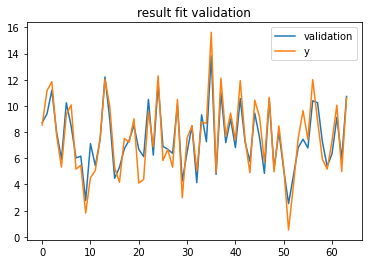

In [174]:
plt.plot(range(len(pred)), pred, label="validation")
plt.plot(range(len(y_test)), y_test, label="y")
plt.legend()
plt.title("result fit validation")
plt.show()

5. On fait une  prédiction sur le jeu de test

(320, 14)


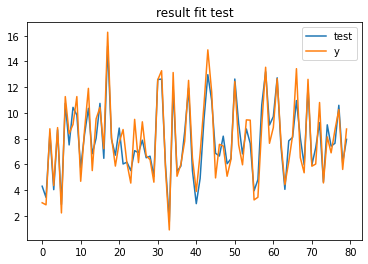

In [179]:
X = df_test.loc[:,  df_test.columns != "Y"].values
y = df_test.loc[:, ["Y"]].values.reshape(-1)

print(x.shape)
res = [[], [], []]
for i in range(0, 3):
    res[i] = model_list[i].predict(X)
df = pd.DataFrame(res)

pred = model_final.predict(df.T.values).reshape(-1)

plt.plot(range(len(pred)), pred, label="test")
plt.plot(range(len(y)), y, label="y")
plt.legend()
plt.title("result fit test")
plt.show()


<AxesSubplot:>

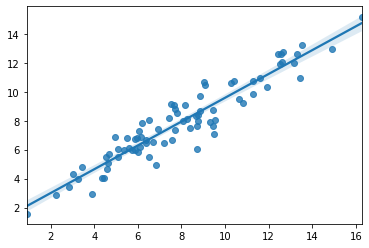

In [181]:
sns.regplot(y, pred)